# Analysis of AirBNB data from Boston
In this analysis, Boston AirBNB data from the listings.csv file downloaded from https://www.kaggle.com/airbnb/boston/data is analyzed according to the CRISP-DM process to answer some questions, mainly relevant for people offereing their accommendations.

## 1. Business understanding
AirBNB is a community based platform in which users can offer their private accommendations to other people. So the platform acts as a kind of broker. Users can earn money by renting their couch, their room, their flats or even a complete houses. Its is assumed that one reason to book a specific accommendation is - beside location, price, and amenities - the rating by other users. Here is shall be analyzed whether there are aspects that users can influence that are corrolated with a high rating.

The following aspects are analyzed in 4. Modelling:
1. Is there a relation between price and ratings?
2. Is there a relation between neighborhoods and ratings and price?
3. Is there a relation between the number of reviews and the rating? In other words: Is the distribution of ratings skewed?
4. Is there a relation between amenities and rating?
5. Is there a way to predict the rating based on the set of information?

Some questions can be answered by directly looking into the dataset. Of course, it is expected that the overall experience during the stay at a location is the most crucial point for the rating. Nevertheless, it is checked here whether the the questions above indicate also other aspects.

## 2. Data understanding
The data is loaded and a number of things are checked to understand the dataset.

In [133]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

df = pd.read_csv('./listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


### Determine the number of rows (entries for specifc accommendations) and columns (different features of the accommendations)

In [2]:
num_rows = df.shape[0] #Contains the number of rows in the dataset
num_cols = df.shape[1] #Contains the number of columns in the dataset

print('The dataset contains', num_rows, 'rows and', num_cols, 'columns.')

('The dataset contains', 3585, 'rows and', 95, 'columns.')


### Check of the columns to find out which are important for this analysis and check their status
The dataset contains many full text columns. They will not be considered here. It is assumed that neighborhood (the cleansed version), the property type, the room type, the accommodates, the bed type, the amenities, the price, the availability, the number of reviews, and of course the rating score itself play a role to answer the business questions above.

In [4]:
no_nulls = set(df.columns[df.isnull().mean()==0])
print(no_nulls)

set(['host_identity_verified', 'listing_url', 'neighbourhood_cleansed', 'street', 'require_guest_profile_picture', 'accommodates', 'country_code', 'is_location_exact', 'availability_365', 'id', 'availability_90', 'availability_60', 'picture_url', 'calendar_last_scraped', 'host_since', 'host_has_profile_pic', 'state', 'amenities', 'host_listings_count', 'maximum_nights', 'cancellation_policy', 'latitude', 'last_scraped', 'instant_bookable', 'description', 'experiences_offered', 'price', 'host_picture_url', 'extra_people', 'smart_location', 'host_verifications', 'number_of_reviews', 'guests_included', 'host_url', 'host_id', 'availability_30', 'calculated_host_listings_count', 'name', 'bed_type', 'country', 'calendar_updated', 'longitude', 'requires_license', 'minimum_nights', 'host_is_superhost', 'host_name', 'require_guest_phone_verification', 'scrape_id', 'host_total_listings_count', 'host_thumbnail_url', 'room_type'])


In [5]:
most_missing_cols = set(df.columns[df.isnull().mean() > 0.5])
print(most_missing_cols)

set(['monthly_price', 'license', 'notes', 'weekly_price', 'has_availability', 'security_deposit', 'neighbourhood_group_cleansed', 'square_feet', 'jurisdiction_names'])


In [6]:
neighbourhood=df['neighbourhood_cleansed'].value_counts()
print(neighbourhood)

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Bay Village                 24
Mattapan                    24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64


In [7]:
property_type=df['property_type'].value_counts()
print(property_type)

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64


In [8]:
room_type=df['room_type'].value_counts()
print(room_type)

Entire home/apt    2127
Private room       1378
Shared room          80
Name: room_type, dtype: int64


In [9]:
bed_type=df['bed_type'].value_counts()
print(bed_type)

Real Bed         3453
Futon              51
Airbed             40
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64


### Check the different amenties which are unfortunately no listed in specific columns: To this end, the code from "Lession 1" has been adapted to generate a plot showing the fraction of each amenty.

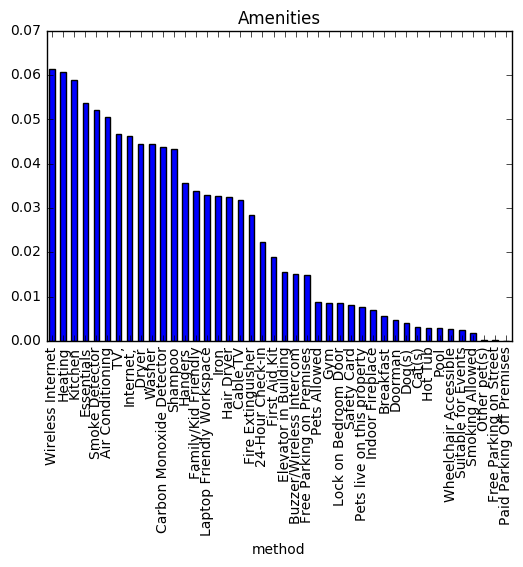

In [10]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of different types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

possible_vals = ["24-Hour Check-in", "Air Conditioning", "Breakfast", "Buzzer/Wireless Intercom", 
                 "Cable TV", "Carbon Monoxide Detector", "Cat(s)", "Dog(s)", "Doorman", ",Dryer",
                 "Elevator in Building", "Essentials", "Family/Kid Friendly", "Fire Extinguisher",
                 "First Aid Kit", "Free Parking on Premises", "Free Parking on Street", "Gym", "Hangers",
                 "Hair Dryer", "Heating", "Hot Tub", "Indoor Fireplace", "Internet,", "Iron", "Kitchen",
                 "Laptop Friendly Workspace", "Lock on Bedroom Door", "Other pet(s)", "Paid Parking Off Premises",
                 "Pets Allowed", "Pets live on this property", "Pool", "Safety Card", "Shampoo", "Smoke Detector",
                 "Smoking Allowed", "Suitable for Events", "TV,", "Washer", "Wheelchair Accessible",
                 "Wireless Internet"]

def clean_and_plot(df, title='Amenities', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['amenities'].value_counts().reset_index()
    study.rename(columns={'index': 'method', 'amenities': 'count'}, inplace=True)
    study_df = total_count(study, 'method', 'count', possible_vals)

    study_df.set_index('method', inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(df)

In [11]:
print(props_df)

                               count
method                              
Wireless Internet           0.061298
Heating                     0.060635
Kitchen                     0.058844
Essentials                  0.053647
Smoke Detector              0.052160
Air Conditioning            0.050547
TV,                         0.046713
Internet,                   0.046175
,Dryer                      0.044366
Washer                      0.044348
Carbon Monoxide Detector    0.043756
Shampoo                     0.043380
Hangers                     0.035568
Family/Kid Friendly         0.033830
Laptop Friendly Workspace   0.032862
Iron                        0.032755
Hair Dryer                  0.032450
Cable TV                    0.031715
Fire Extinguisher           0.028347
24-Hour Check-in            0.022344
First Aid Kit               0.019047
Elevator in Building        0.015553
Buzzer/Wireless Intercom    0.015033
Free Parking on Premises    0.014890
Pets Allowed                0.008708
G

### Check the relation between between higher availablity and number of ratings
The idea is is that highly frequented accommendations get more ratings.
At first it is checked wether the columns are complete and contain no NaNs.

In [84]:
print(df_prepared["availability_30"].isnull().value_counts())
print(df_prepared["availability_60"].isnull().value_counts())
print(df_prepared["availability_90"].isnull().value_counts())
print(df_prepared["availability_365"].isnull().value_counts())
print(df_prepared["number_of_reviews"].isnull().value_counts())

False    3585
Name: availability_30, dtype: int64
False    3585
Name: availability_60, dtype: int64
False    3585
Name: availability_90, dtype: int64
False    3585
Name: availability_365, dtype: int64
False    3585
Name: number_of_reviews, dtype: int64


The columns are complete. The correlation coefficients are calculated and corresponding scatter plots are generated to check whether there is some correlation between these the measures.

Pearson correlation coefficient:
-0.0713077638848


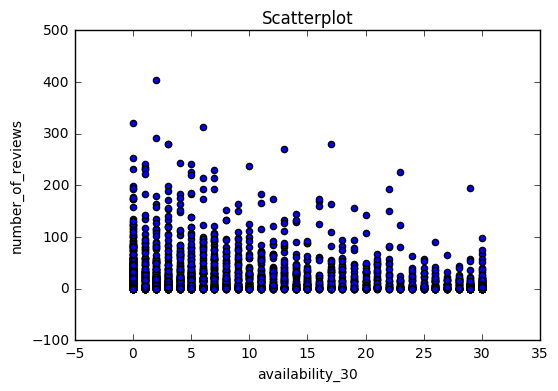

In [85]:
df.plot.scatter(x='availability_30', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_30'].corr(df['number_of_reviews']))

Pearson correlation coefficient:
-0.032168777022


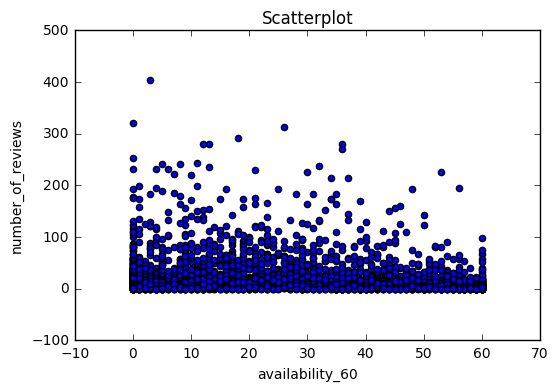

In [86]:
df.plot.scatter(x='availability_60', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_60'].corr(df['number_of_reviews']))

Pearson correlation coefficient:
0.0221655649374


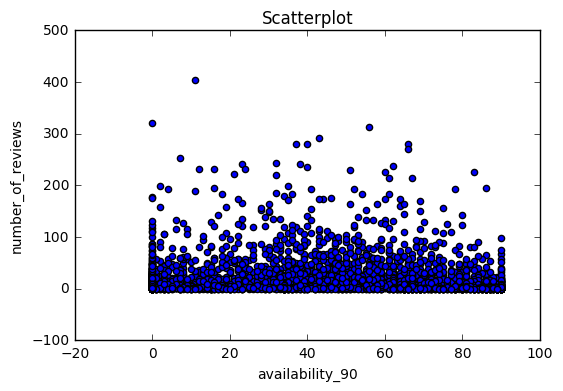

In [87]:
df.plot.scatter(x='availability_90', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_90'].corr(df['number_of_reviews']))

Pearson correlation coefficient:
0.192289165624


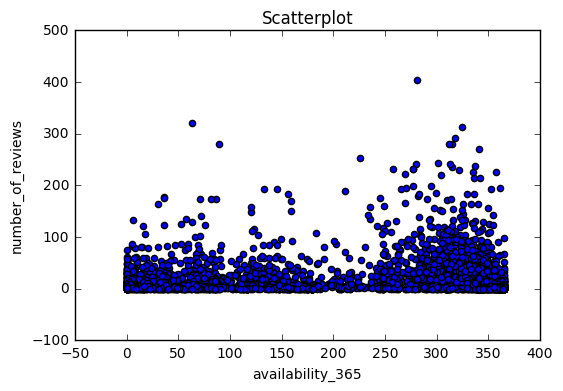

In [88]:
df.plot.scatter(x='availability_365', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_365'].corr(df['number_of_reviews']))

No consistent correlation is visible. Thus, the availablity is not considered in the further analysis steps.

## 3. Data preparation

In [119]:
df_prepared = df.copy() # Copy the original dataset into a new dataframe which is then step-by-step changed

### Correction of the price column
The price column contains unfortunately no number values but strings due to a leading "$" symbol and commas as 1000-seperators. Furthermore, the two decimal digits are always "0" and are, therefore, useless. Thus, these things are removed and the price is converted to int values. After that, the price distribution is plotted.

In [120]:
df_prepared['price'] = df_prepared['price'].map(lambda i: (i[1:])) # Remove leading "$"
df_prepared['price'] = df_prepared['price'].map(lambda i: (i[:-3])) # Remove decimal values (last 3 characters)
df_prepared['price'] = df_prepared['price'].map(lambda i: int(i.replace(",", ""))) # Remove commas and convert to int

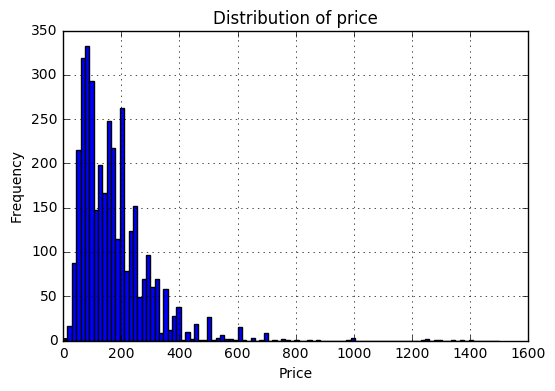

In [121]:
df_prepared['price'].hist(bins=100, range=(0, 1500))
plt.title("Distribution of price")
plt.xlabel('Price')
plt.ylabel('Frequency')

### Replacement of the amenities column by specific columns for each amenity
The amenities column is tricky, since it contains strings of all types of combinations of amenities. This is replaced by specific columns with boolean values.

In [122]:
df_prepared['24HourCheckin']          =df_prepared['amenities'].map(lambda i: "24-Hour Check-in" in i)
df_prepared['airConditioning']        =df_prepared['amenities'].map(lambda i: "Air Conditioning" in i)
df_prepared['breakfast']              =df_prepared['amenities'].map(lambda i: "Breakfast" in i)
df_prepared['buzzerWirelessIntercom'] =df_prepared['amenities'].map(lambda i: "Buzzer/Wireless Intercom" in i)
df_prepared['cableTV']                =df_prepared['amenities'].map(lambda i: "Cable TV" in i)
df_prepared['carbonMonoxideDetector'] =df_prepared['amenities'].map(lambda i: "Carbon Monoxide Detector" in i)
df_prepared['cats']                   =df_prepared['amenities'].map(lambda i: "Cat(s)" in i)
df_prepared['dogs']                   =df_prepared['amenities'].map(lambda i: "Dog(s)" in i)
df_prepared['doorman']                =df_prepared['amenities'].map(lambda i: "Doorman" in i)
df_prepared['dryer']                  =df_prepared['amenities'].map(lambda i: ",Dryer" in i) # Prohibits match in "Hair Dryer"
df_prepared['elevatorInBuilding']     =df_prepared['amenities'].map(lambda i: "Elevator in Building" in i)
df_prepared['essentials']             =df_prepared['amenities'].map(lambda i: "Essentials" in i)
df_prepared['familyKidFriendly']      =df_prepared['amenities'].map(lambda i: "Family/Kid Friendly" in i)
df_prepared['fireExtinguisher']       =df_prepared['amenities'].map(lambda i: "Fire Extinguisher" in i)
df_prepared['firstAidKit']            =df_prepared['amenities'].map(lambda i: "First Aid Kit" in i)
df_prepared['freeParkingOnPremises']  =df_prepared['amenities'].map(lambda i: "Free Parking on Premises" in i)
df_prepared['freeParkingOnStreet']    =df_prepared['amenities'].map(lambda i: "Free Parking on Street" in i)
df_prepared['gym']                    =df_prepared['amenities'].map(lambda i: "Gym" in i)
df_prepared['hangers']                =df_prepared['amenities'].map(lambda i: "Hangers" in i)
df_prepared['hairDryer']              =df_prepared['amenities'].map(lambda i: "Hair Dryer" in i)
df_prepared['heating']                =df_prepared['amenities'].map(lambda i: "Heating" in i)
df_prepared['hotTub']                 =df_prepared['amenities'].map(lambda i: "Hot Tub" in i)
df_prepared['indoorFireplace']        =df_prepared['amenities'].map(lambda i: "Indoor Fireplace" in i)
df_prepared['internet']               =df_prepared['amenities'].map(lambda i: "Internet," in i) # Prohibits match in "Cable TV"
df_prepared['iron']                   =df_prepared['amenities'].map(lambda i: "Iron" in i)
df_prepared['kitchen']                =df_prepared['amenities'].map(lambda i: "Kitchen" in i)
df_prepared['laptopFriendlyWorkspace']=df_prepared['amenities'].map(lambda i: "Laptop Friendly Workspace" in i)
df_prepared['lockOnBedroomDoor']      =df_prepared['amenities'].map(lambda i: "Lock on Bedroom Door" in i)
df_prepared['otherPets']              =df_prepared['amenities'].map(lambda i: "Other pet(s)" in i)
df_prepared['paidParkingOffPremises'] =df_prepared['amenities'].map(lambda i: "Paid Parking Off Premises" in i)
df_prepared['petsAllowed']            =df_prepared['amenities'].map(lambda i: "Pets Allowed" in i)
df_prepared['petsLiveOnThisProperty'] =df_prepared['amenities'].map(lambda i: "Pets live on this property" in i)
df_prepared['pool']                   =df_prepared['amenities'].map(lambda i: "Pool" in i)
df_prepared['safetyCard']             =df_prepared['amenities'].map(lambda i: "Safety Card" in i)
df_prepared['shampoo']                =df_prepared['amenities'].map(lambda i: "Shampoo" in i)
df_prepared['smokeDetector']          =df_prepared['amenities'].map(lambda i: "Smoke Detector" in i)
df_prepared['smokingAllowed']         =df_prepared['amenities'].map(lambda i: "Smoking Allowed" in i)
df_prepared['suitableForEvents']      =df_prepared['amenities'].map(lambda i: "Suitable for Events" in i)
df_prepared['tV']                     =df_prepared['amenities'].map(lambda i: "TV," in i) # Prohibits match in "Cable TV"
df_prepared['washer']                 =df_prepared['amenities'].map(lambda i: "Washer" in i)
df_prepared['wheelchairAccessible']   =df_prepared['amenities'].map(lambda i: "Wheelchair Accessible" in i)
df_prepared['wirelessInternet']       =df_prepared['amenities'].map(lambda i: "Wireless Internet" in i)

del df_prepared['amenities']


In [18]:
df_prepared.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,pool,safetyCard,shampoo,smokeDetector,smokingAllowed,suitableForEvents,tV,washer,wheelchairAccessible,wirelessInternet
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,False,False,True,True,False,False,True,True,False,True
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,False,False,True,True,False,False,True,True,False,True
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,False,True,True,True,False,False,True,True,False,True
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,False,True,True,True,False,False,True,True,False,True
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,False,False,True,True,False,False,False,False,False,True


### Removing or impeding rows

In [123]:
print(df_prepared["review_scores_rating"].isnull().value_counts())

False    2772
True      813
Name: review_scores_rating, dtype: int64


29% of the review scores ratings contain no value. Since the goal is to predict this column later on, the missing rows will be removed.

In [124]:
df_reduced=df_prepared.dropna(subset=['review_scores_rating'], axis=0)

# 4. Modelling

### Is there a relation between price and ratings?

Pearson correlation coefficient:
0.105650594823


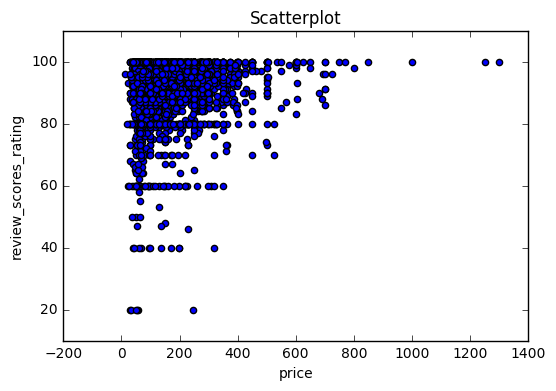

In [129]:
df_reduced.plot.scatter(x='price', y='review_scores_rating')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_reduced['price'].corr(df_reduced['review_scores_rating']))

There seems to be a slight correleation between price and rating. The higher the price, the higher is the rating. In higher price region, there are no real bad ratings.

### Is there a relation between neighborhoods and ratings and price?

In [136]:
df_reduced.groupby('neighbourhood_cleansed').mean()['review_scores_rating'].sort_values(ascending=False)

neighbourhood_cleansed
Leather District           98.333333
Roslindale                 95.380000
West Roxbury               95.212121
South Boston Waterfront    94.431034
Jamaica Plain              94.159322
Longwood Medical Area      94.000000
South Boston               93.980392
North End                  93.725000
Charlestown                93.697368
Beacon Hill                93.378698
South End                  93.264925
Bay Village                93.000000
Downtown                   92.432203
Hyde Park                  92.280000
Chinatown                  92.121951
Back Bay                   91.531646
Mattapan                   91.000000
Brighton                   90.864662
West End                   90.333333
East Boston                90.272059
Allston                    90.164835
Roxbury                    89.803419
Fenway                     89.417112
Dorchester                 89.280000
Mission Hill               87.695122
Name: review_scores_rating, dtype: float64

In [132]:
df_reduced.groupby('neighbourhood_cleansed').mean()['price'].sort_values(ascending=False)

neighbourhood_cleansed
South Boston Waterfront    263.810345
Bay Village                250.875000
Leather District           242.666667
Chinatown                  239.195122
Back Bay                   237.164557
Downtown                   234.906780
Beacon Hill                216.881657
West End                   212.407407
South End                  207.873134
Charlestown                193.460526
North End                  190.350000
South Boston               189.888889
Fenway                     189.320856
Jamaica Plain              136.288136
Roxbury                    135.905983
East Boston                118.830882
Brighton                   114.368421
Mission Hill               107.804878
Longwood Medical Area      105.666667
Allston                    105.417582
West Roxbury                96.484848
Roslindale                  95.460000
Hyde Park                   94.120000
Dorchester                  91.875556
Mattapan                    76.111111
Name: price, dtype: float64

It is not analyzed in more details here, but it seems that neighbourhoods with a higher rating also have a higher mean price and vice versa.